In [8]:
# So we can import our modules
import sys
sys.path.append('../..')

from src.utils.misc import set_device
from src.utils.data import load_split, get_transforms
from src.utils.model import parse_model_filename, load_model, predict
from src.utils.xai_zennit import generate_zennit_explanations
from src.utils.xai_visualization import visualize_explanation
from src.datasets.pornography_frame_dataset import PornographyFrameDataset

import numpy as np

import torch.nn.functional as F
from torch.utils.data import DataLoader

from zennit.attribution import Gradient, SmoothGrad, IntegratedGradients, Occlusion
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat

In [9]:
device = set_device()

Device: cpu


In [10]:
MODEL_PATH = "../../results/pornography-2k/cnns/data-aug/even-20/models/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20.pth"

model_filename, model_name, split = parse_model_filename(MODEL_PATH)
model = load_model(model_name, MODEL_PATH, device)
model.eval()

Loading vgg19...


DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [11]:
DATA_LOC = "/nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20"
INPUT_SHAPE = 224
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 4

data_transforms = get_transforms(
    data_aug=False, 
    input_shape=INPUT_SHAPE, 
    norm_mean=NORM_MEAN, 
    norm_std=NORM_STD
)["test"]
dataset = PornographyFrameDataset(
    data_loc=DATA_LOC, 
    df=load_split(DATA_LOC, split, "test")["test"], 
    transform=data_transforms
)
dataloader = DataLoader(dataset, BATCH_SIZE)

Loaded split.
test: total (8000); porn (4020); non-porn (3980)


In [12]:
def display(orig_image, attribution):
    visualize_explanation(
        image=orig_image,
        attr=np.array(attribution),
        colormap="jet",
        side_by_side=True,
        norm_mean=NORM_MEAN,
        norm_std=NORM_STD,
    ).show()

In [17]:
name, input, label, _ = dataset["vPorn000564#4.jpg"]
input = input.unsqueeze(0).to(device)
conf, pred = predict(model, input)
print(f"{name} - predicted: {pred.item()} (confidence: {conf.item()})")

vPorn000564#4.jpg - predicted: 1 (confidence: 0.9981623291969299)


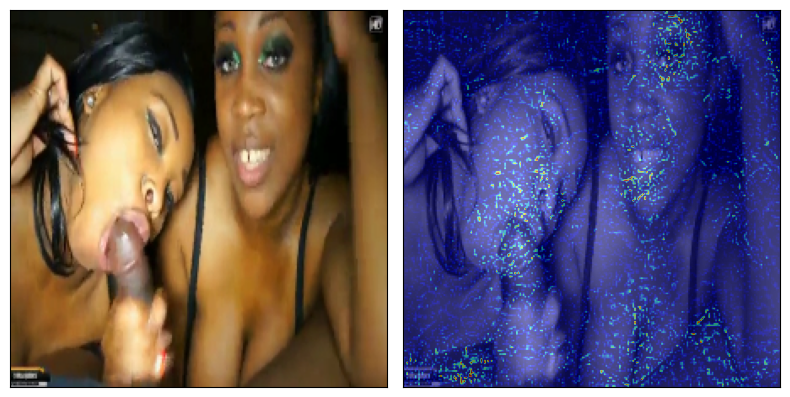

In [19]:
attrs = generate_zennit_explanations(
    model=model,
    inputs=input,
    targets=pred,
    method_name="Gradient"
)
display(input,attrs[0])

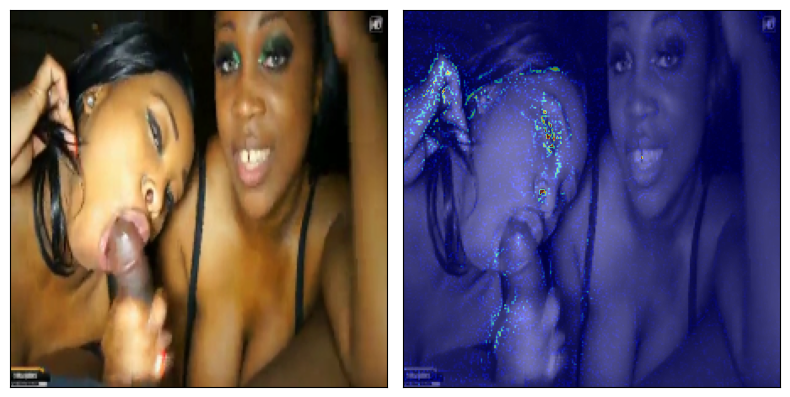

In [20]:
attrs = generate_zennit_explanations(
    model=model, 
    inputs=input, 
    targets=pred, 
    method_name="SmoothGrad", 
    method_kwargs={"noise_level": 0.1, "n_iter": 20}
)
display(input, attrs[0])

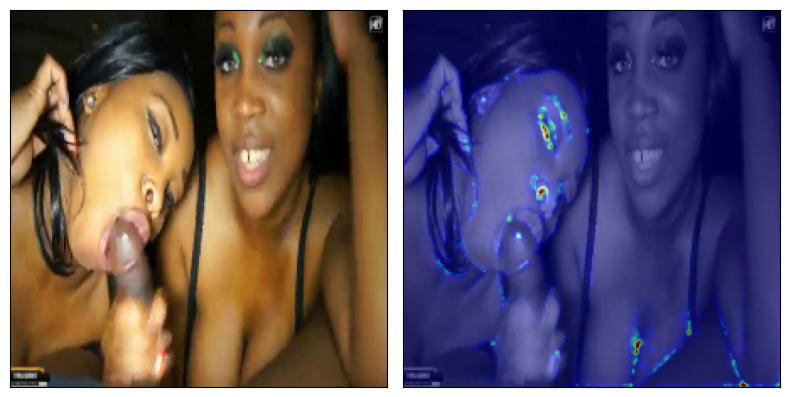

In [24]:
import torch
# LRP 'default' rule
attrs = generate_zennit_explanations(
    model=model,
    inputs=input,
    targets=pred,
    method_name="Gradient",
    composite_name="EpsilonGammaBox",
    composite_kwargs={"low": -2.12, "high": 2.64},
)
display(input, attrs[0])

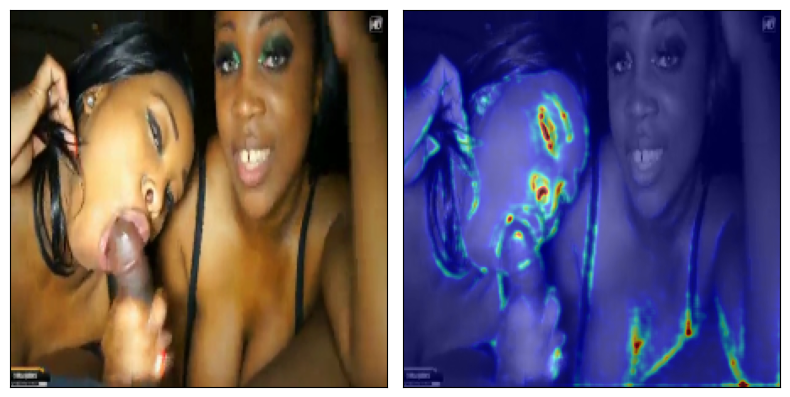

In [25]:
# LRP composite rule
attrs = generate_zennit_explanations(
    model=model,
    inputs=input,
    targets=pred,
    method_name="Gradient",
    composite_name="EpsilonPlusFlat",
)
display(input, attrs[0])

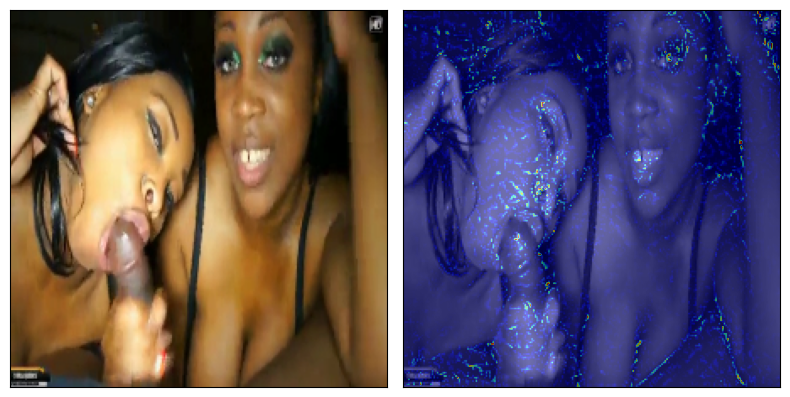

In [26]:
# baseline_fn parameter defaults to torch.zeros_like
attrs = generate_zennit_explanations(
    model=model,
    inputs=input,
    targets=pred,
    method_name="IntegratedGradients",
    method_kwargs={"n_iter": 50},
)
display(input, attrs[0])

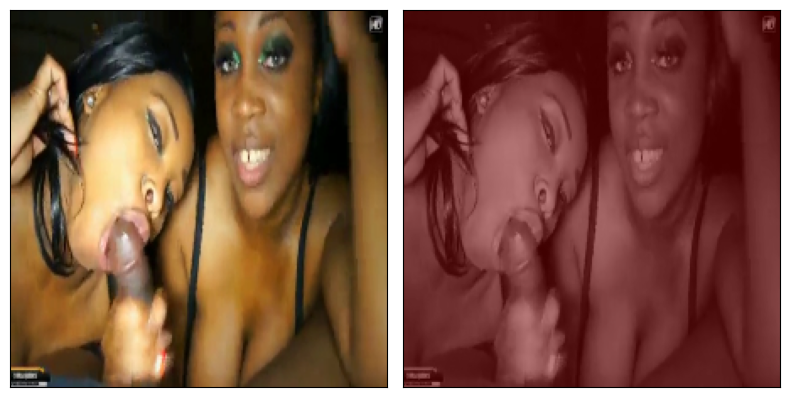

In [27]:
# it occludes inside the sliding window, whereas captum occludes inside it
attrs = generate_zennit_explanations(
    model=model,
    inputs=input,
    targets=pred,
    method_name="Occlusion",
    method_kwargs={"window": 8, "stride": 4},
)
display(input, attrs[0])